This tutorial explains how to evaluate the privacy of synthetic smart meter data. This notebook is based on the Faraday architecture, trained on Low Carbon London dataset.

- For more information on Faraday's architecture, refer to the [Faraday paper](https://arxiv.org/abs/2404.04314).
- For more information on evaluation method, refer to the paper by Centre for Net Zero on [Defining 'Good': Evaluation Framework for Synthetic Smart Meter Data
](https://arxiv.org/abs/2407.11785). 

---

### Pre-requisites

1. If you haven't already, please download LCL dataset from [data.london.gov.uk](https://data.london.gov.uk/dataset/smartmeter-energy-use-data-in-london-households).
2. If you haven't already, you need to first train a model (refer to the `faraday_tutorial.ipynb` notebook).


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

import logging
logging.basicConfig(level=logging.INFO)

# 💿 Loading LCL Data

In [3]:
from pathlib import Path
from opensynth.data_modules.lcl_data_module import LCLDataModule
import pytorch_lightning as pl

import matplotlib.pyplot as plt

data_path = Path("../../data/processed/historical/train/lcl_data.csv")
stats_path = Path("../../data/processed/historical/train/mean_std.csv")
outlier_path = Path("../../data/processed/historical/train/outliers.csv")

# Original training data with no outliers
dm = LCLDataModule(data_path=data_path, stats_path=stats_path, batch_size=200, n_samples=20000)
dm.setup()

In [4]:
# Training data with implausible outliers injected for privacy attacks
dm_with_outliers = LCLDataModule(data_path=data_path, stats_path=stats_path, batch_size=200, n_samples=20000, outlier_path=outlier_path)
dm_with_outliers.setup()

# 🤖 Load Pretrained Faraday model

In [5]:
from opensynth.models.faraday.model import FaradayModel
import numpy as np
import torch

In [42]:
faraday1500 = torch.load("faraday_model_1500.pt", weights_only=False)
faraday150 = torch.load("faraday_model_150.pt", weights_only=False)
faraday50 = torch.load("faraday_model_50.pt", weights_only=False)
faraday10 = torch.load("faraday_model_10.pt", weights_only=False)
faraday1 = torch.load("faraday_model_1.pt", weights_only=False)

# 1️⃣ Reconstruction Attack

### 🏭 Create Reconstruction Attack Dataset

In [32]:
from opensynth.evaluation.privacy import reconstruction_attack

faraday1500_attack_dataset = reconstruction_attack.create_attack_dataset(
    model=faraday1500, dm=dm_with_outliers, n_samples=10000
)

faraday150_attack_dataset = reconstruction_attack.create_attack_dataset(
    model=faraday150, dm=dm_with_outliers, n_samples=10000
)

faraday50_attack_dataset = reconstruction_attack.create_attack_dataset(
    model=faraday50, dm=dm_with_outliers, n_samples=10000
)

faraday10_attack_dataset = reconstruction_attack.create_attack_dataset(
    model=faraday10, dm=dm_with_outliers, n_samples=10000
)
faraday1_attack_dataset = reconstruction_attack.create_attack_dataset(
    model=faraday1, dm=dm_with_outliers, n_samples=10000
)

### 🧮 Calculating pair-wise euclidean distances

In [33]:

faraday1500_distance_norm = reconstruction_attack.calculate_distance_norm(
    real = faraday1500_attack_dataset.real_samples,
    fake = faraday1500_attack_dataset.synthetic_samples,
    group_min=True
)

faraday150_distance_norm = reconstruction_attack.calculate_distance_norm(
    real = faraday150_attack_dataset.real_samples,
    fake = faraday150_attack_dataset.synthetic_samples,
    group_min=True
)

faraday50_distance_norm = reconstruction_attack.calculate_distance_norm(
    real = faraday50_attack_dataset.real_samples,
    fake = faraday50_attack_dataset.synthetic_samples,
    group_min=True
)

faraday10_distance_norm = reconstruction_attack.calculate_distance_norm(
    real = faraday10_attack_dataset.real_samples,
    fake = faraday10_attack_dataset.synthetic_samples,
    group_min=True
)

faraday1_distance_norm = reconstruction_attack.calculate_distance_norm(
    real = faraday1_attack_dataset.real_samples,
    fake = faraday1_attack_dataset.synthetic_samples,
    group_min=True
)

INFO:opensynth.evaluation.privacy.reconstruction_attack:Calculating pairwise euclidean distance..
INFO:opensynth.evaluation.privacy.reconstruction_attack:Converting wide to long table..
INFO:opensynth.evaluation.privacy.reconstruction_attack:Calculating vector norm..
INFO:opensynth.evaluation.privacy.reconstruction_attack:Calculating pairwise euclidean distance..
INFO:opensynth.evaluation.privacy.reconstruction_attack:Converting wide to long table..
INFO:opensynth.evaluation.privacy.reconstruction_attack:Calculating vector norm..
INFO:opensynth.evaluation.privacy.reconstruction_attack:Calculating pairwise euclidean distance..
INFO:opensynth.evaluation.privacy.reconstruction_attack:Converting wide to long table..
INFO:opensynth.evaluation.privacy.reconstruction_attack:Calculating vector norm..
INFO:opensynth.evaluation.privacy.reconstruction_attack:Calculating pairwise euclidean distance..
INFO:opensynth.evaluation.privacy.reconstruction_attack:Converting wide to long table..
INFO:opens

### 📈 Plotting cumulative distribution function

(0.0, 1.0)

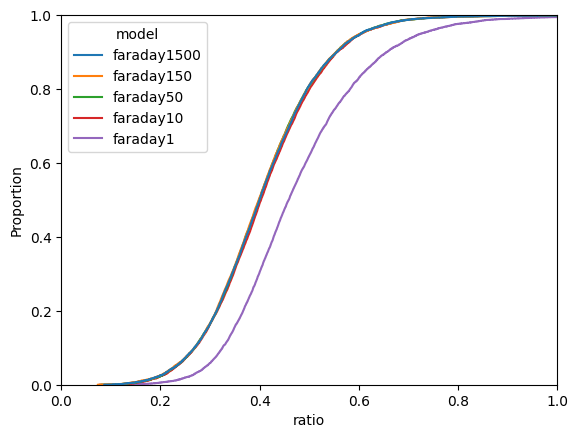

In [64]:
import pandas as pd
import seaborn as sns


faraday1500_distance_norm["model"] = "faraday1500"
faraday150_distance_norm["model"] = "faraday150"
faraday50_distance_norm["model"] = "faraday50"
faraday10_distance_norm["model"] = "faraday10"
faraday1_distance_norm["model"] = "faraday1"

df_reconstruction_attack_results = pd.concat([
    faraday1500_distance_norm,
    faraday150_distance_norm,
    faraday50_distance_norm,
    faraday10_distance_norm,
    faraday1_distance_norm
]).reset_index(drop=True)

sns.ecdfplot(data=df_reconstruction_attack_results, x="ratio", hue="model")
plt.xlim(0, 1)